This notebook explores the graph segmentation stage and evaluate the performance of the track candidates.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
from acctrack.io.pyg_data_reader import TrackGraphDataReader
from acctrack.io.reco_trkx import RecoTrkxReader
import numpy as np
import pandas as pd
import acctrack.tools.tracks_from_gnn as track_builder
import acctrack.tools.evaluate_reco_tracks as track_eval
import acctrack.viewer.plotter as plotter
from matplotlib import pyplot as plt


uproot is not installed. AthenaRawRootReader will not be available.


In [3]:
evtid = 5020
tf_infer_filename = "/pscratch/sd/x/xju/ITk/ForFinalPaper/gnn4itk/tfgraphs/gnn_val_v3/5020.npz"
torch_data_filename = "/global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset"
outdir = "/pscratch/sd/x/xju/ITk/ForFinalPaper/gnn4itk/tfgraphs/track_candidates"


Build track candidates

In [4]:
track_builder.process(
    tf_infer_filename, torch_data_filename, outdir,
    method_name="build_tracks_dbscan",
    score_name="score",
    edge_score_cut=0.01,
    epsilon=0.1,
    min_samples=3
)

/global/homes/x/xju/.conda/envs/gnn4itk/lib/python3.9/site-packages/sklearn/neighbors/_base.py:234: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


Evaluate the track candidates

In [5]:
reader = TrackGraphDataReader(torch_data_filename, name="GNN")
data = reader.read(0)

df_particles = pd.DataFrame({"particle_id": data.particle_id, "pt": data.pt})
print(df_particles.shape)
df_particles = df_particles.drop_duplicates(subset=["particle_id"])
print("after duplicate removal", df_particles.shape)

# read reco tracks
hit_id = data.hit_id
reco_reader = RecoTrkxReader(outdir)
submission = reco_reader(evtid)

track_id = np.zeros(hit_id.shape[0], dtype=np.int64)
track_id[submission.hit_id] = submission.track_id

pids = np.zeros(hit_id.shape[0], dtype=np.int64)
pids[data.track_edges[0]] = data.particle_id
pids[data.track_edges[1]] = data.particle_id
df_reco = pd.DataFrame({"hit_id": hit_id, "track_id": track_id, "particle_id": pids})

GNN: Total 3 events in directory: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset
Reading file: /global/homes/x/xju/m3443/usr/xju/ITk/For2023Paper/metric_learning_testing/trainset/event000005020.pyg
(103066, 2)
after duplicate removal (12212, 2)


In [6]:
min_track_length = min_particle_length = 1
matching_df = track_eval.get_matching_df(
    df_reco,
    df_particles,
    min_track_length=min_track_length,
    min_particle_length=min_particle_length,
)
matching_df["event_id"] = int(evtid)

In [7]:
matching_df = track_eval.calculate_matching_fraction(matching_df)
matching_fraction = 0.5
matching_df["is_matched"] = matching_df["is_reconstructed"] = (
    matching_df.purity_reco >= matching_fraction
)

In [8]:
hist_opts = {
    "histtype": "step",
    "lw": 2,
}

In [9]:
pid_cuts = (matching_df.particle_id != 0) & (matching_df.n_true_hits > 5)
matching_cuts = pid_cuts & (matching_df.is_matched == True)

In [10]:
particles_of_interest = matching_df[pid_cuts].drop_duplicates(subset=["event_id", "particle_id"])
particles_of_interest.shape

(8951, 13)

In [11]:
tracks = matching_df.drop_duplicates(subset=["event_id", "track_id"])
tracks

,track_id,particle_id,n_shared,n_reco_hits,n_true_hits,pt,is_matchable,is_reconstructable,event_id,purity_reco,eff_true,is_matched,is_reconstructed
0,-1,0,87870,138320,149834,NaN,True,True,5020,0.635266,0.586449,True,True
10485,0,0,59202,70595,149834,NaN,True,True,5020,0.838615,0.395117,True,True
15852,1,5900000000562,22,22,23,869.872,True,True,5020,1.000000,0.956522,True,True
15853,2,5430000001285,6,6,15,235.179,True,True,5020,1.000000,0.400000,True,True
15854,3,5760000000153,6,6,17,385.885,True,True,5020,1.000000,0.352941,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23883,7514,5270000200404,3,3,9,543.254,True,True,5020,1.000000,0.333333,True,True
23884,7515,5370000200015,3,3,13,626.710,True,True,5020,1.000000,0.230769,True,True
23885,7516,5260000200285,3,3,10,424.976,True,True,5020,1.000000,0.300000,True,True
23886,7517,5150000001561,3,3,18,346.086,True,True,5020,1.000000,0.166667,True,True


In [12]:
tracks[tracks.particle_id != 0].shape

(6863, 13)

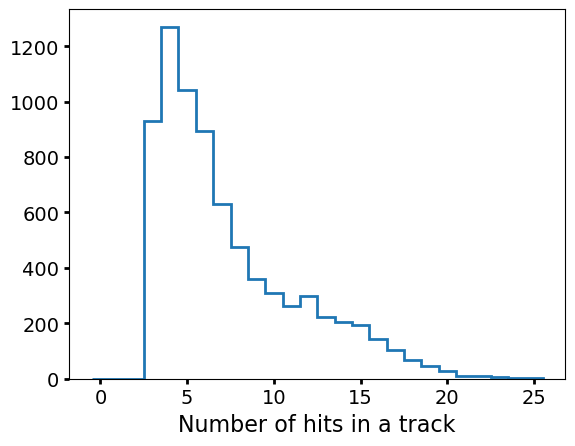

In [13]:
plt.hist(tracks.n_reco_hits, bins=26, range=(-0.5, 25.5), **hist_opts)
plt.xlabel("Number of hits in a track")
plt.show()

In [14]:
reco_tracks = tracks[(tracks.purity_reco > 0.5) & (tracks.particle_id != 0) & (tracks.n_reco_hits > 2)]

In [15]:
matched_pids, counts = np.unique(reco_tracks.particle_id, return_counts=True)
n_matched_particles = matched_pids.shape[0]
n_duplicated_tracks = np.sum(counts > 1)
print("Number of matched particles:", n_matched_particles)
print("Number of duplicated tracks:", n_duplicated_tracks)

Number of matched particles: 5667
Number of duplicated tracks: 1008


In [16]:
matched_particles = particles_of_interest[particles_of_interest.particle_id.isin(reco_tracks.particle_id)]
matched_particles

,track_id,particle_id,n_shared,n_reco_hits,n_true_hits,pt,is_matchable,is_reconstructable,event_id,purity_reco,eff_true,is_matched,is_reconstructed
1,-1,969,3,138320,9,80375.300,True,True,5020,0.000022,0.333333,False,False
2,-1,1032,8,138320,11,1526.980,True,True,5020,0.000058,0.727273,False,False
3,-1,1034,3,138320,9,550.850,True,True,5020,0.000022,0.333333,False,False
4,-1,1037,4,138320,10,2130.540,True,True,5020,0.000029,0.400000,False,False
5,-1,1041,3,138320,10,8669.540,True,True,5020,0.000022,0.300000,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23133,6823,4560000000163,8,8,13,903.599,True,True,5020,1.000000,0.615385,True,True
23266,6948,5630000000123,11,11,11,923.345,True,True,5020,1.000000,1.000000,True,True
23267,6949,5150000001538,7,7,7,1936.640,True,True,5020,1.000000,1.000000,True,True
23272,6953,5150000001511,12,12,12,1416.450,True,True,5020,1.000000,1.000000,True,True


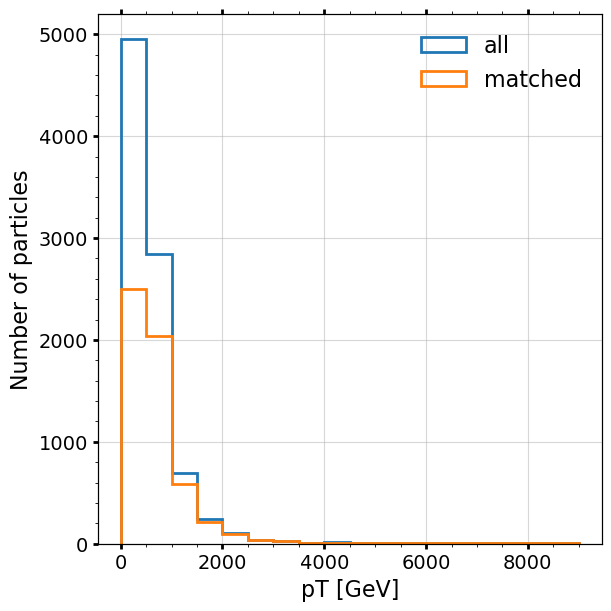

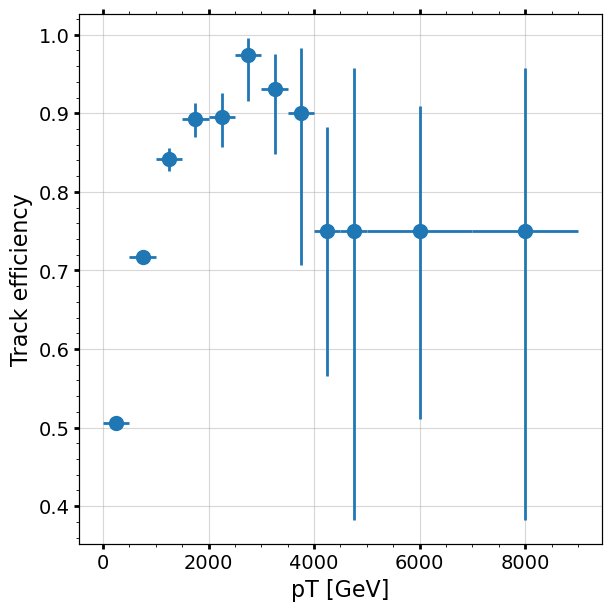

In [17]:
pt_bins = np.arange(0, 5000, step=500).tolist() + np.arange(5000, 11000, step=2000.0).tolist()
pt_configs = {"bins": pt_bins, "histtype": "step", "lw": 2, "log": False}
plotter.make_cmp_plot(
    [particles_of_interest.pt, matched_particles.pt],
    configs=pt_configs,
    xlabel="pT [GeV]",
    outname="pt_cmp",
    legends=["all", "matched"],
    ylabel="Number of particles",
    ratio_label="Track efficiency",
    ratio_legends=None
)